##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

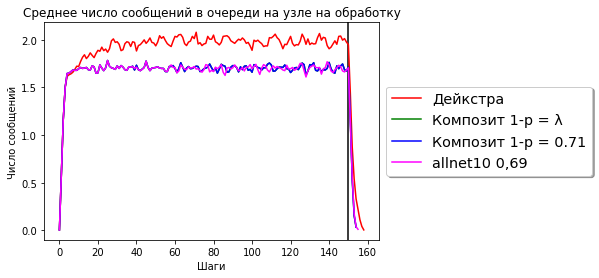

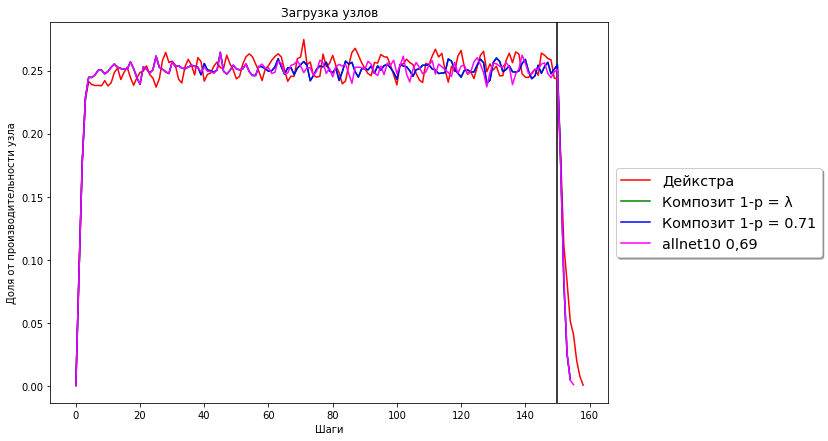

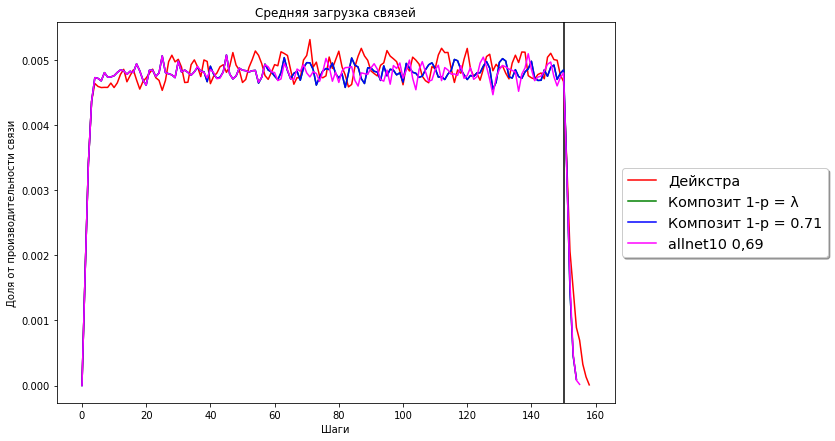

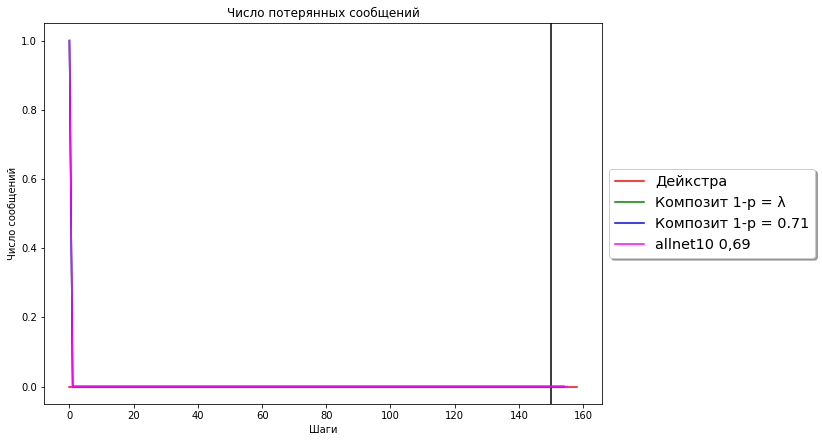

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71
Доставлено 15000 Потеряно 0.0067% -allnet10 0,69


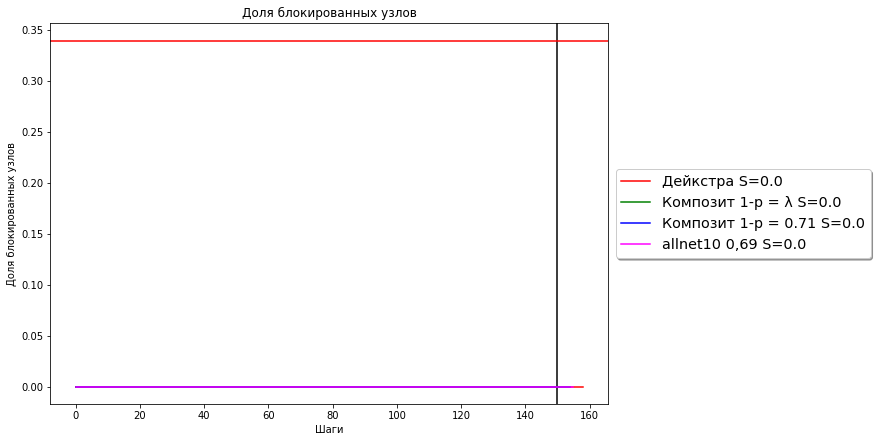

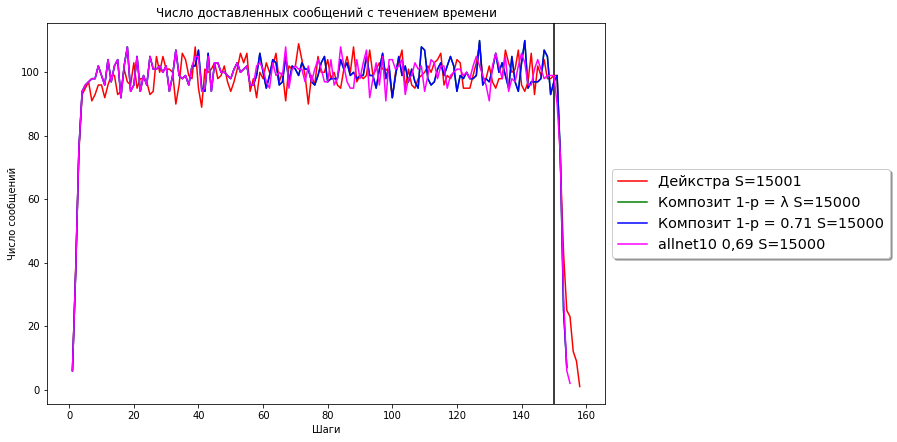

In [2]:
log_tags = [
 {"tag":  "e44c1ddb-c92e-403f-ba89-ce6036019a38", "label": "Дейкстра", "color": "red"},
# {"tag":  "2b650059-299c-4719-a35e-8e60331d0d22", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "876a590e-13cd-4499-b5d1-d8649cb1fe94", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2b8475d2-b512-497d-ab52-5fb8dda0dedc", "label": "Композит 1-p = 0.71", "color": "blue"},
  {"tag":  "da30fb90-20b5-450b-9eb3-e168786f1e32", "label": "allnet10 0,69", "color": "magenta"},
 
]
quantity = 100; 
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

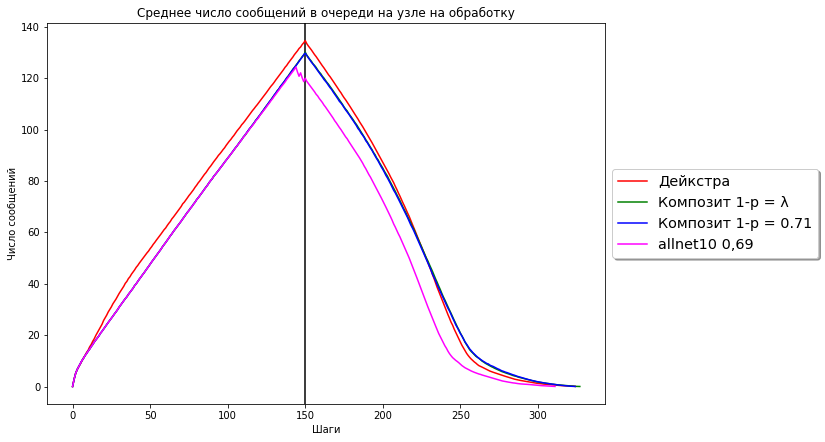

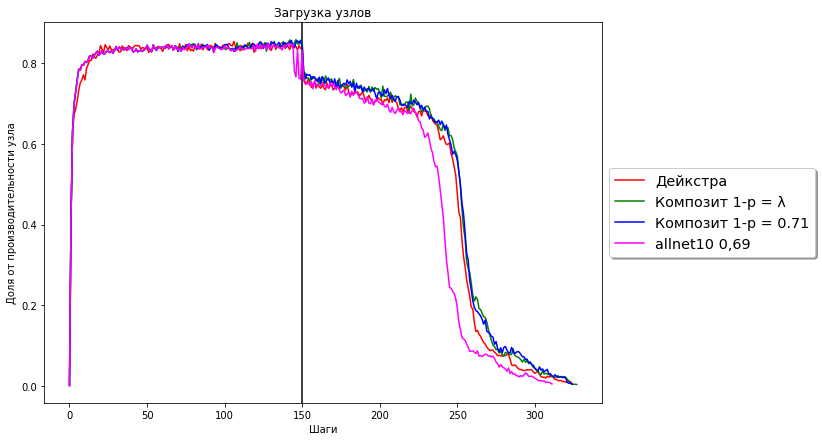

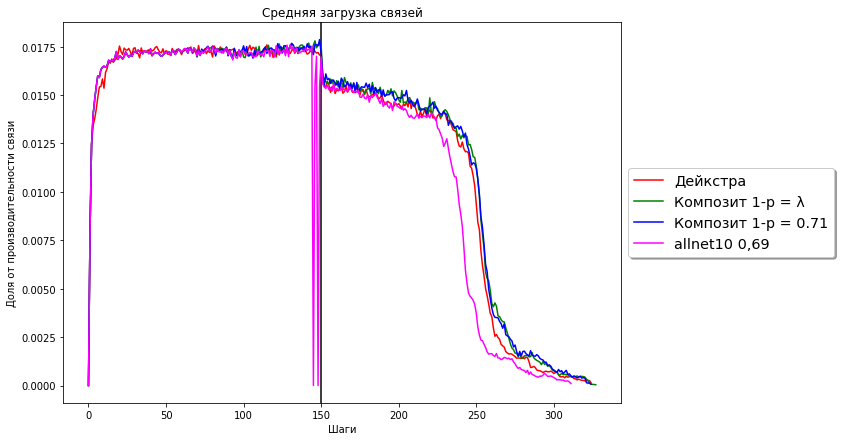

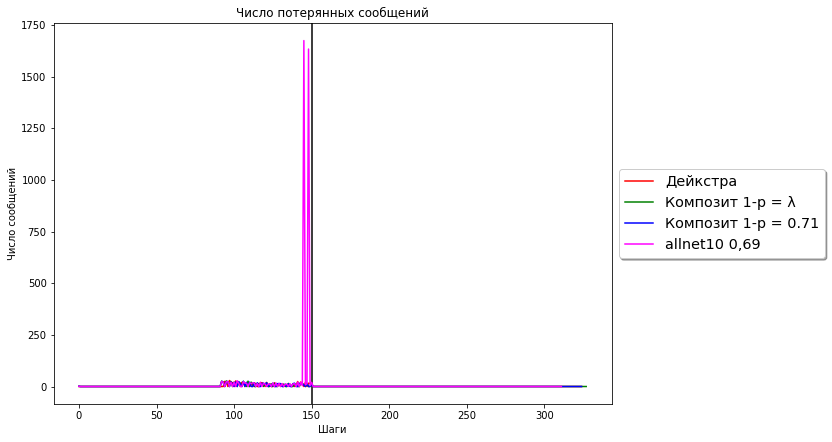

Доставлено 74375 Потеряно 0.8347% -Дейкстра
Доставлено 74452 Потеряно 0.7320% -Композит 1-p = λ
Доставлено 74457 Потеряно 0.7253% -Композит 1-p = 0.71
Доставлено 71091 Потеряно 5.2133% -allnet10 0,69


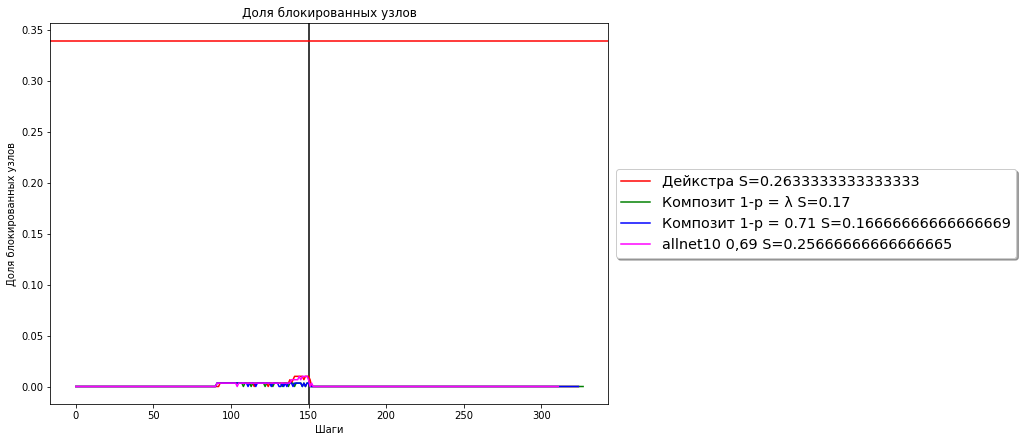

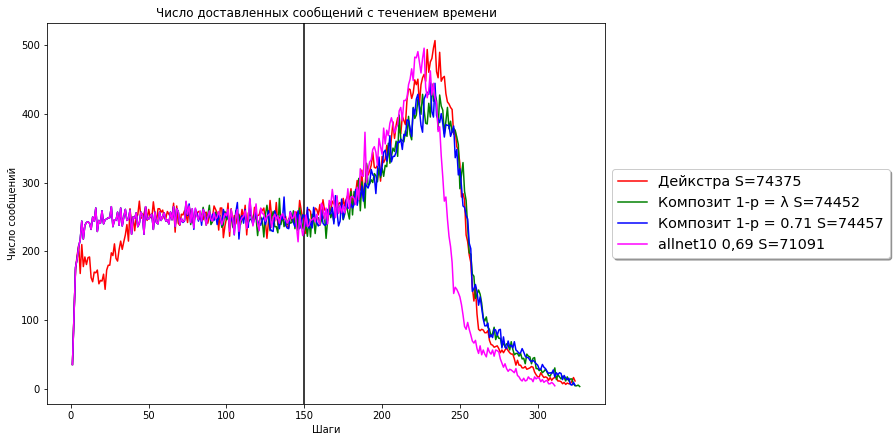

In [3]:
log_tags = [
 {"tag":  "2bda8fe6-b92c-4150-8858-8b2e043cf750", "label": "Дейкстра", "color": "red"},
 #{"tag":  "07b446ae-f69e-436d-8eb0-5ef918e50bce", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "596e80ea-847c-4288-bc17-67d92db85ef7", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "25e50da9-9acd-4d94-83d2-f8deeee2df38", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "d7877c70-2c7f-4cd6-b70c-8f319443becd", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

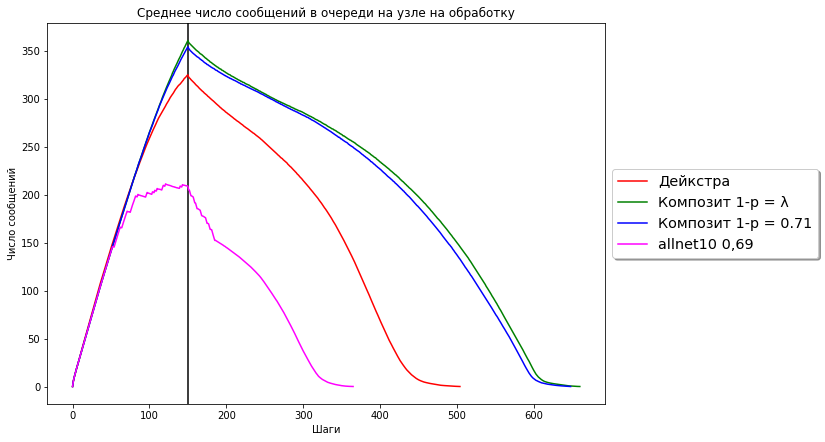

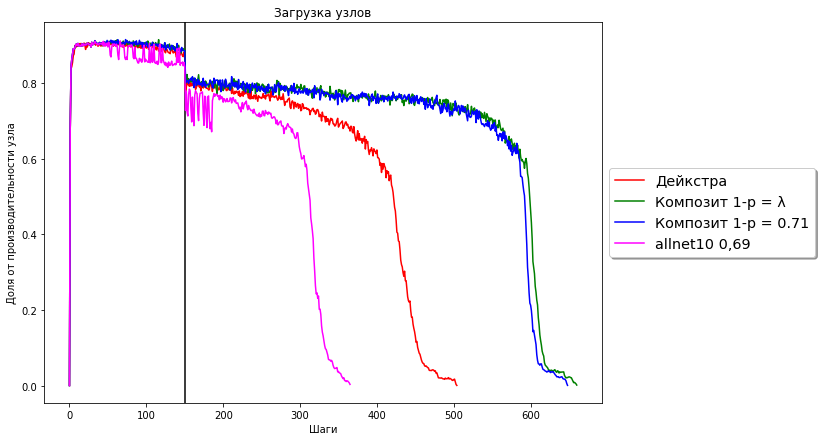

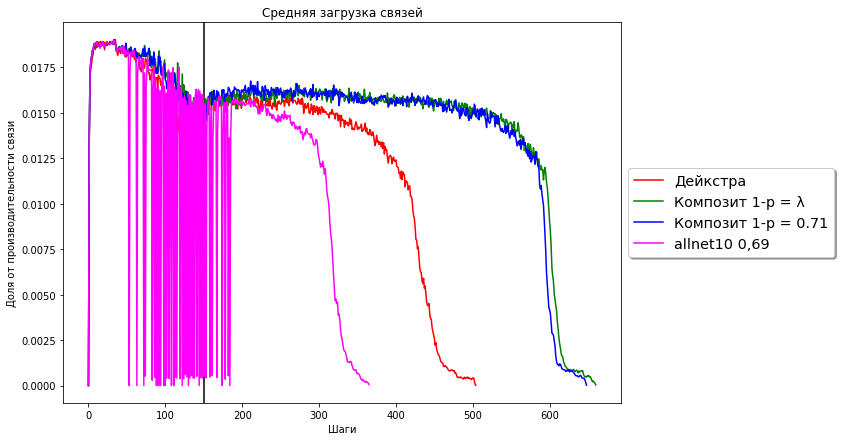

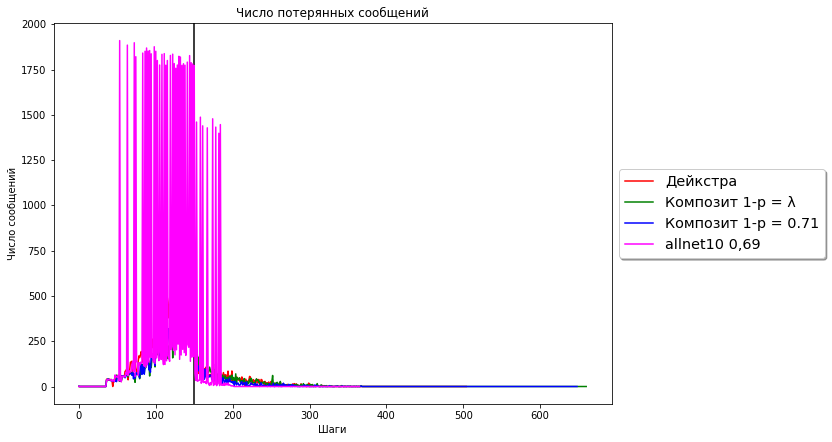

Доставлено 114524 Потеряно 23.6512% -Дейкстра
Доставлено 124819 Потеряно 16.7879% -Композит 1-p = λ
Доставлено 125451 Потеряно 16.3666% -Композит 1-p = 0.71
Доставлено 68111 Потеряно 54.5930% -allnet10 0,69


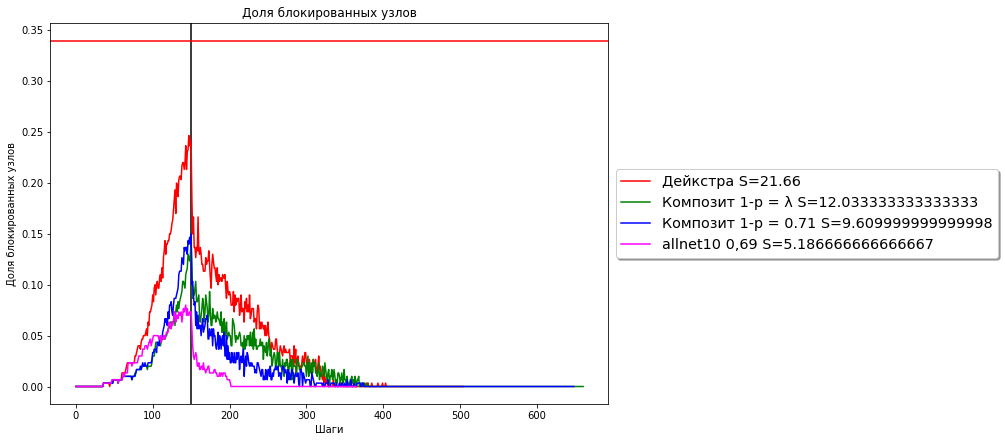

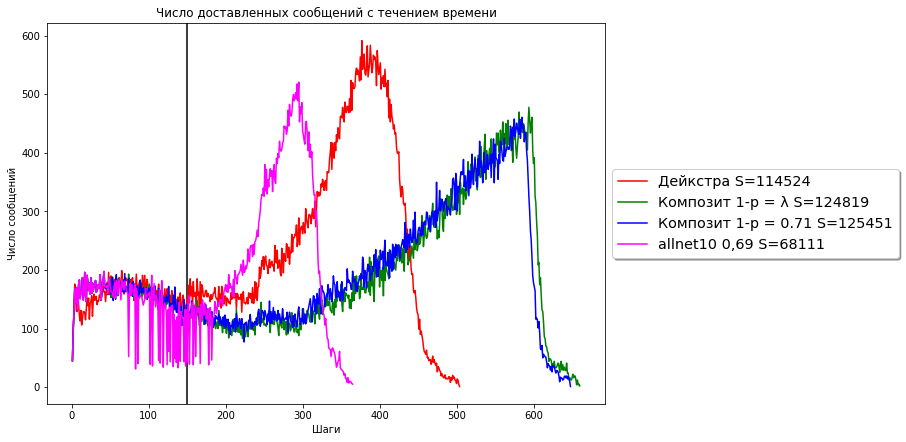

In [4]:
log_tags = [
 {"tag":  "78991048-e3a4-4352-bfb4-4b1ee57c94e4", "label": "Дейкстра", "color": "red"},
 #{"tag":  "1155413f-6d21-499d-90b3-3e01b5de6bb3", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "ac30cc58-b32d-475d-beba-7e092b58e9eb", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "9b0f1d5c-08f0-41f9-9123-9c9f6b27cb6a", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "5e8bfaf2-84d1-4263-b588-ce1fd544c4c2", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

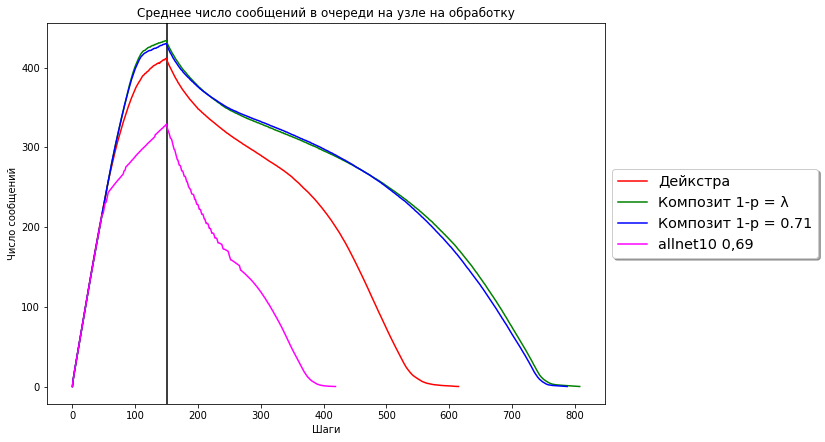

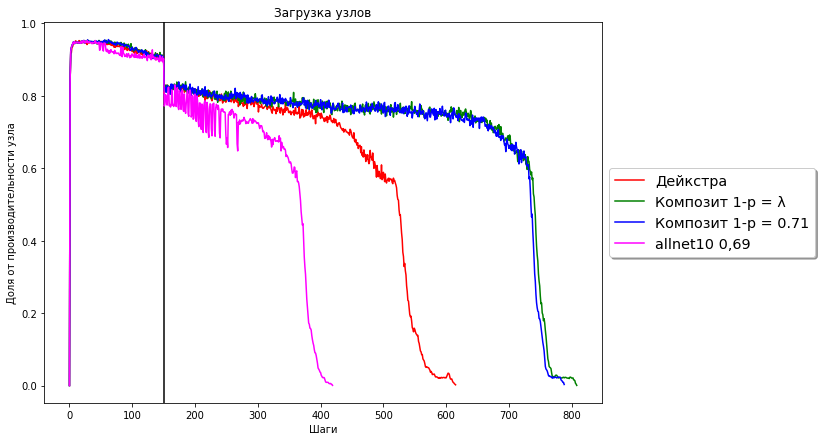

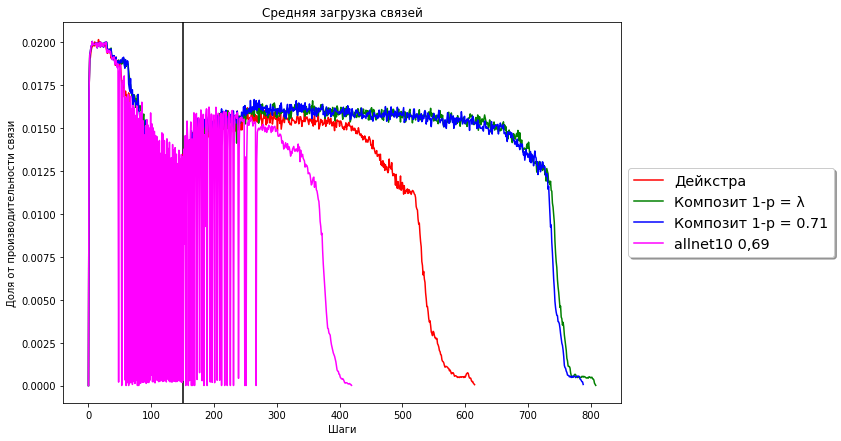

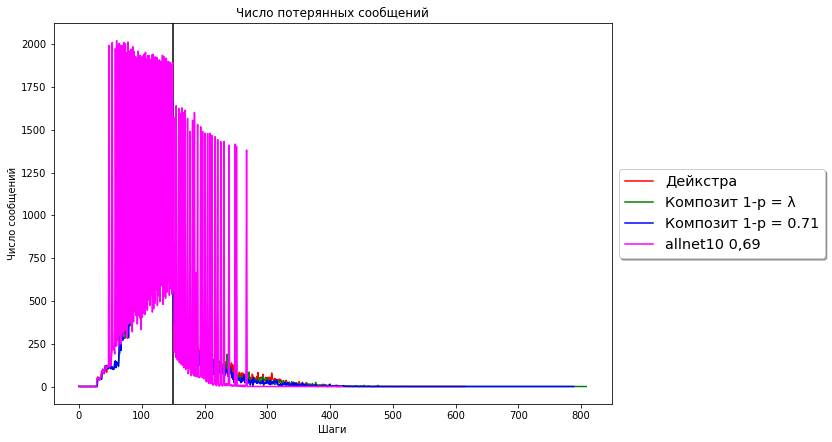

Доставлено 113170 Потеряно 49.7024% -Дейкстра
Доставлено 121095 Потеряно 46.1802% -Композит 1-p = λ
Доставлено 123195 Потеряно 45.2469% -Композит 1-p = 0.71
Доставлено 65067 Потеряно 71.0815% -allnet10 0,69


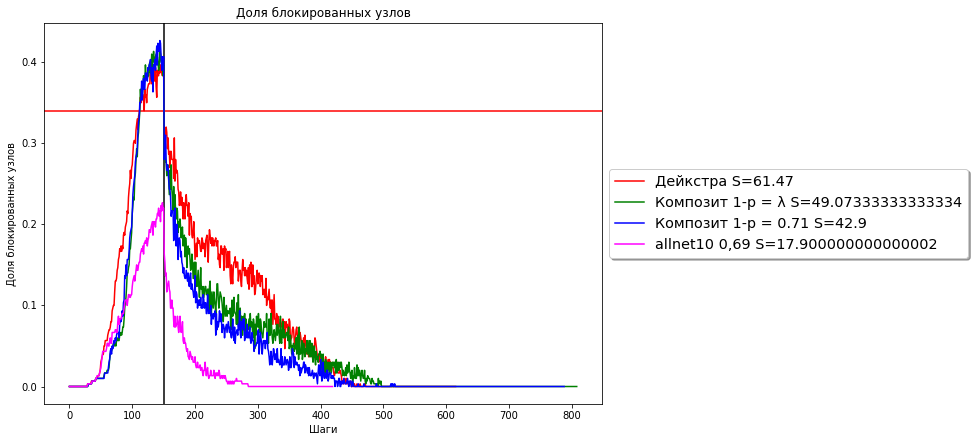

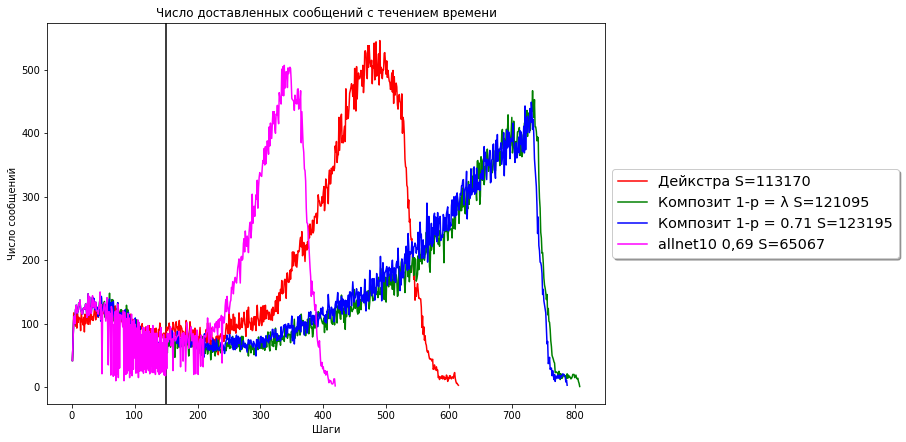

In [5]:
log_tags = [
 {"tag":  "34ea270d-0f81-4a6b-9461-af44eb150688", "label": "Дейкстра", "color": "red"},
 #{"tag":  "4a376c54-9280-41b7-9d71-0bb8653f7014", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "2abf418f-d038-4c4a-a783-ee97ea827272", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "d1211bb4-2a46-4826-bddb-4bece89f2921", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "f00ce4fe-e90e-4a1f-a11f-c04836629cb7", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44783 Потеряно 0.4844% -Дейкстра
Доставлено 44738 Потеряно 0.5844% -Композит 1-p = λ
Доставлено 44738 Потеряно 0.5844% -Композит 1-p = 0.71
Доставлено 44738 Потеряно 0.5844% -allnet10 0,69


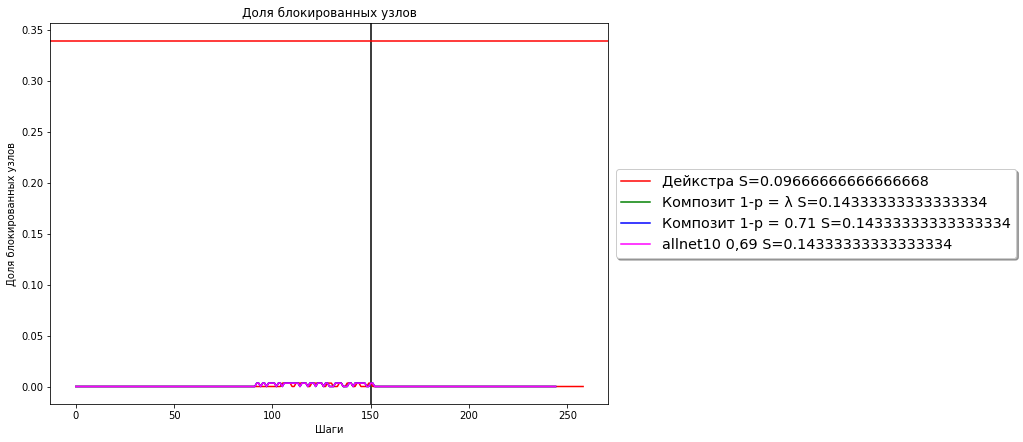

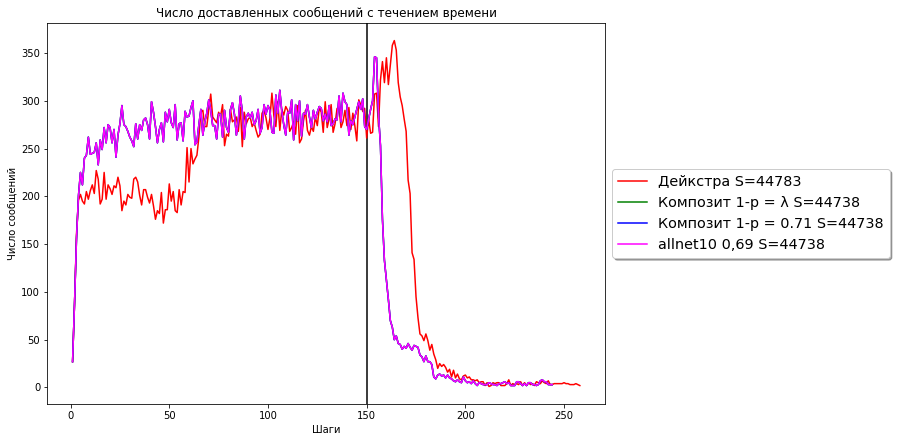

Доставлено 98581 Потеряно 6.1142% -Дейкстра
Доставлено 101225 Потеряно 3.5962% -Композит 1-p = λ
Доставлено 101047 Потеряно 3.7657% -Композит 1-p = 0.71
Доставлено 64140 Потеряно 38.9149% -allnet10 0,69


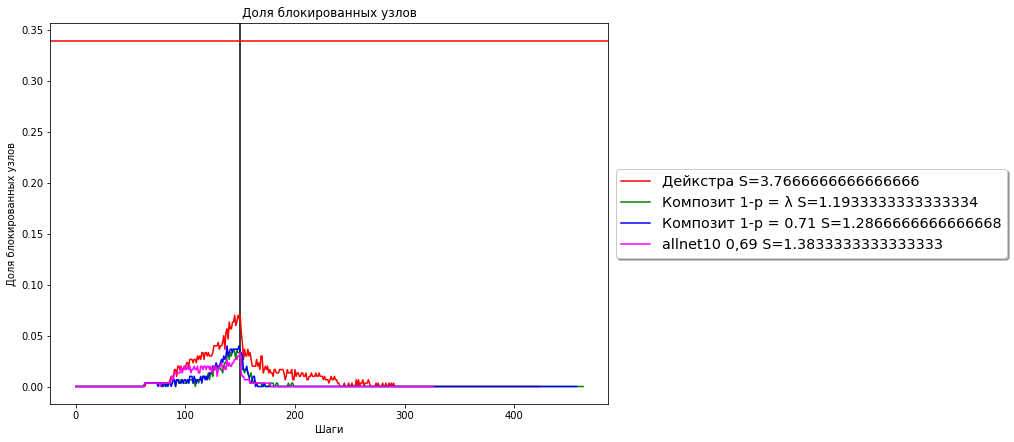

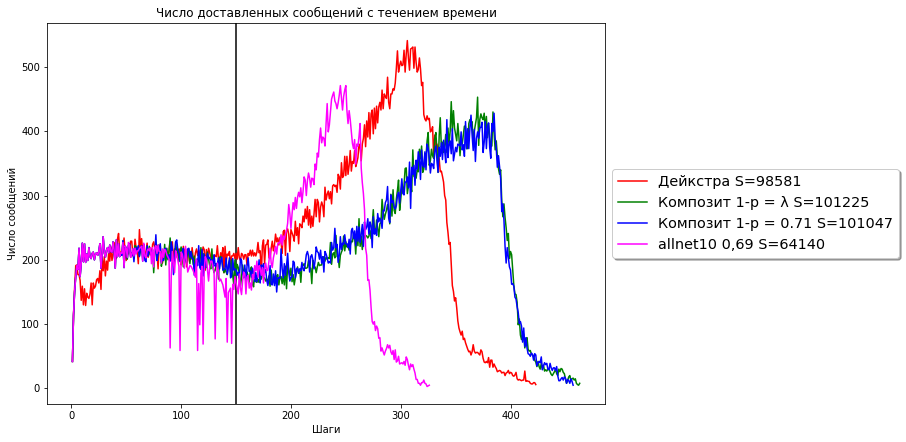

Доставлено 111814 Потеряно 17.1754% -Дейкстра
Доставлено 119818 Потеряно 11.2466% -Композит 1-p = λ
Доставлено 119130 Потеряно 11.7562% -Композит 1-p = 0.71
Доставлено 65521 Потеряно 51.4663% -allnet10 0,69


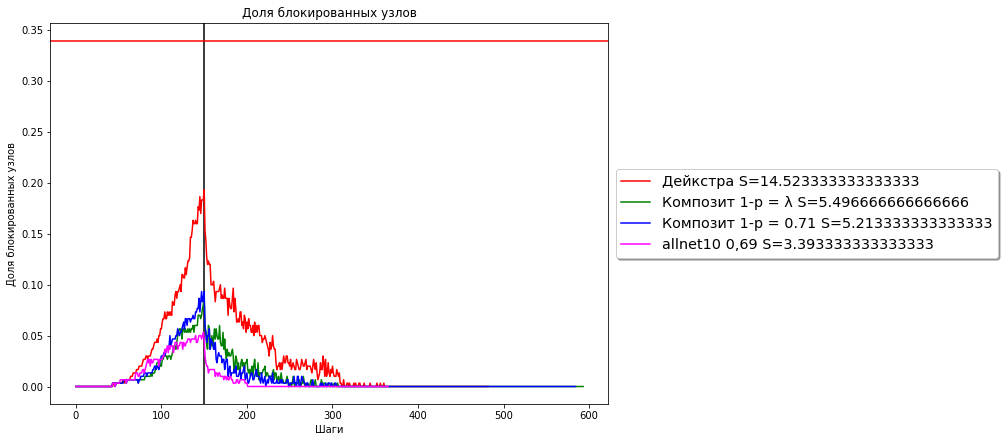

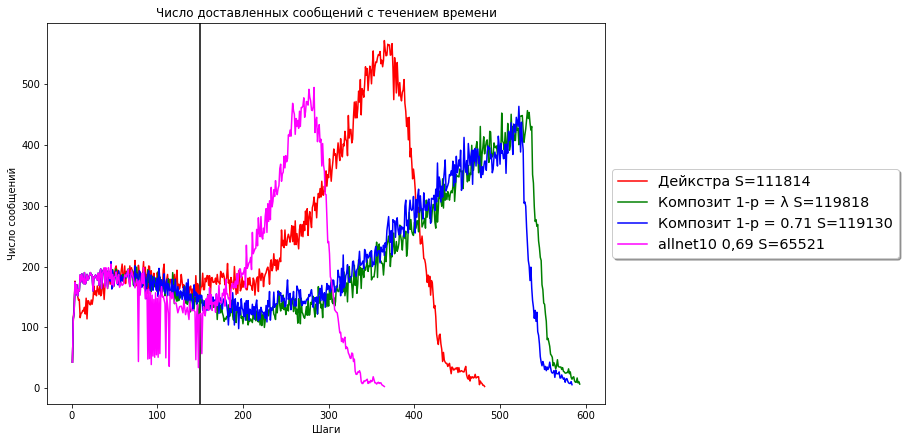

Доставлено 118202 Потеряно 34.3326% -Дейкстра
Доставлено 127920 Потеряно 28.9337% -Композит 1-p = λ
Доставлено 129490 Потеряно 28.0615% -Композит 1-p = 0.71
Доставлено 68948 Потеряно 61.6958% -allnet10 0,69


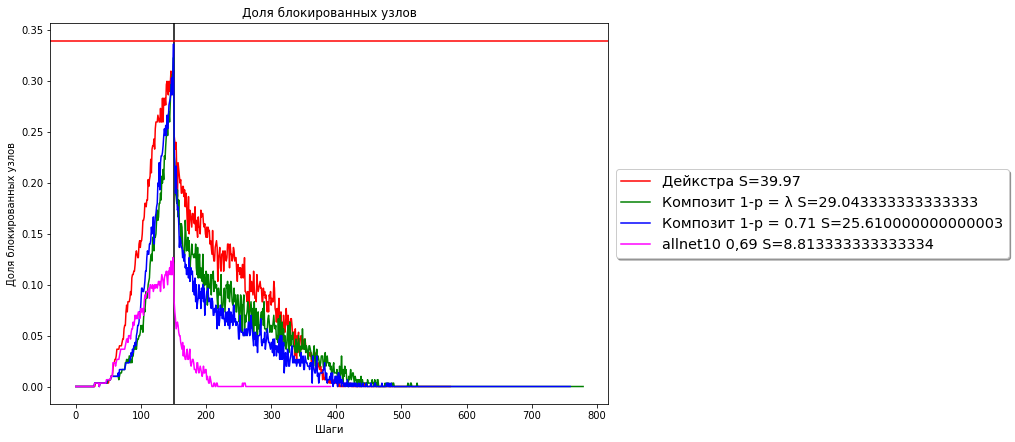

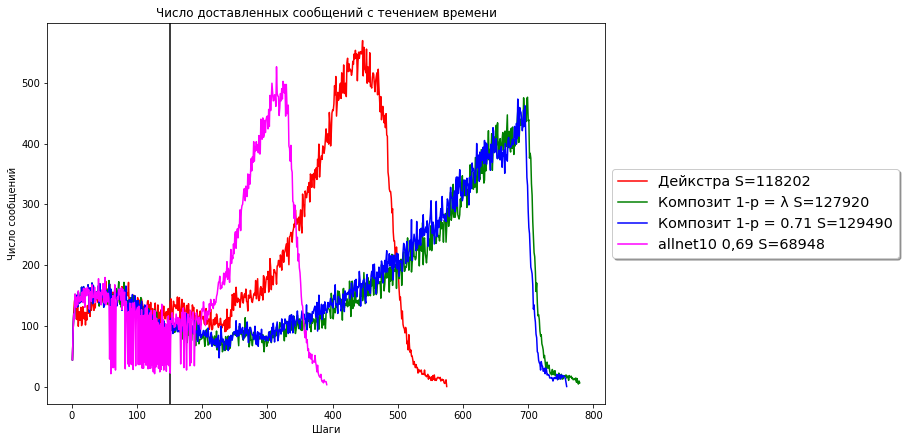

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "d36f423c-6897-4314-80ae-a62a39a641a3", "label": "Дейкстра", "color": "red"},
 {"tag":  "f3af71f1-b3f0-4d12-bcea-73aac34e7346", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "94dac544-2ed6-4499-9872-d19fdfec14c6", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "dea8b41a-3e2e-4c50-a60a-ae9d59e7ae1f", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "b525f9e5-1723-4ce3-aad0-f0c3f1f69244", "label": "Дейкстра", "color": "red"},
 {"tag":  "b7348c51-3bdf-4a18-b0f3-62557823b1ee", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "1ba48b79-fafc-44d2-845f-4908f6db47b9", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "6a541996-11d6-49d2-89d5-92c52e2a2cd2", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "2021469e-9b36-4445-b60a-db6f7dfc55ad", "label": "Дейкстра", "color": "red"},
 {"tag":  "30dd4042-4fba-40aa-ba29-e0fcf635c047", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "0258bd05-4194-4aa8-99d8-de006cc56c03", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "e863d2e0-5995-4c5a-be2a-df60593eeda2", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 1200;  
log_tags = [
 {"tag":  "80df76a1-2d95-40e6-b1d7-b60a2dcd91ef", "label": "Дейкстра", "color": "red"},
 {"tag":  "9335a915-99a5-476e-a86b-2bf7e2718199", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "4fd2ddd3-976e-42a3-8ca3-c49a20ccbfb6", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "6a90f194-ce57-4062-9766-d8ba820d938d", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

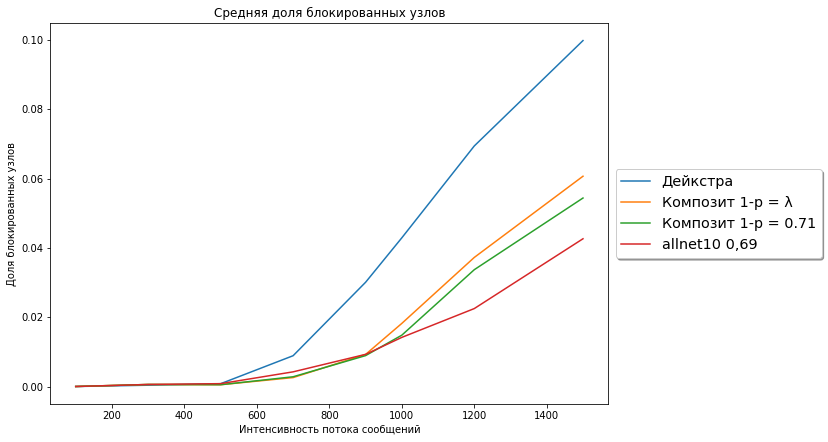

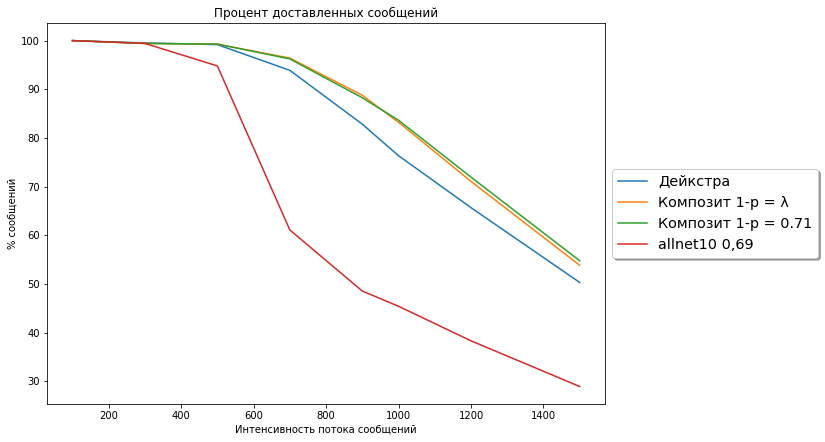

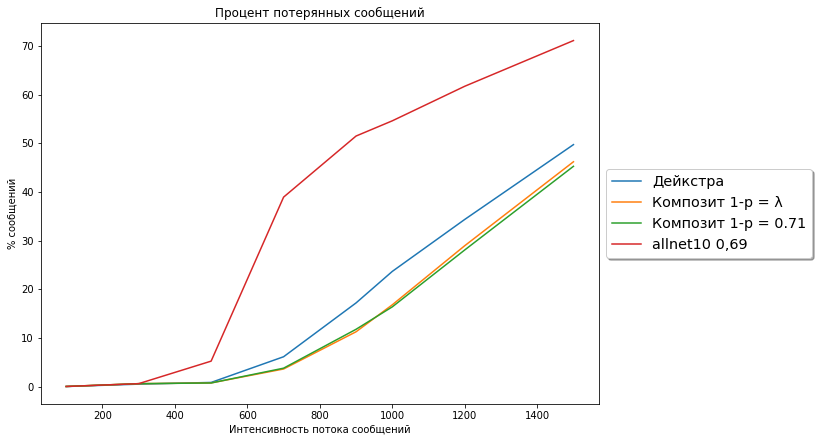

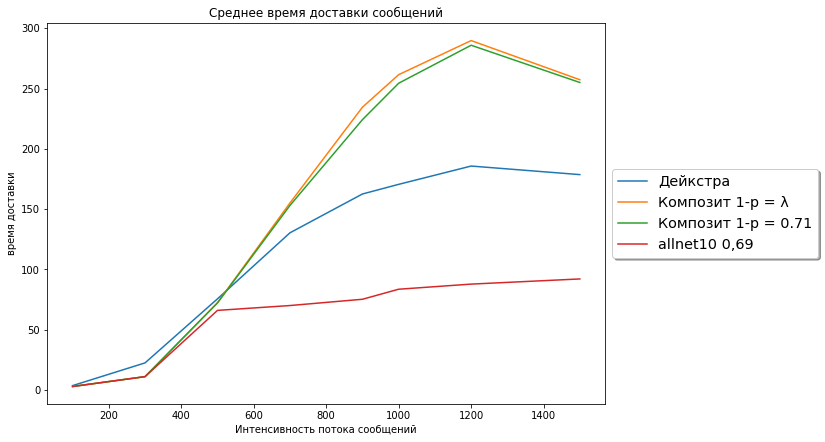

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.031526
Композит 1-p = λ       0.016128
Композит 1-p = 0.71    0.014462
allnet10 0,69          0.011773

Дейкстра               16.536869
Композит 1-p = λ       13.508460
Композит 1-p = 0.71    13.314161
allnet10 0,69          35.444464

Дейкстра               116.252997
Композит 1-p = λ       160.619115
Композит 1-p = 0.71    157.398272
allnet10 0,69           61.175582
